# Speech Emotion Recognition

Tujuan notebook ini adalah untuk mengklasifikasikan emosi berdasarkan gelombang suara mentah menjadi 6 kategori emosi:
1. Happy (Bahagia) dengan nilai 0
2. Sad (Sedih) dengan nilai 1
3. Neutral (Netral) dengan nilai 2
4. Fear (Takut) dengan nilai 3
5. Angry (Marah) dengan nilai 4
6. Disgust (Jijik) dengan nilai 5 

Langkah-langkah yang dilakukan:
1. Pengumpulan data
2. Eksplorasi Data Singkat (EDA)
3. Praproses
4. Ekstraksi fitur
5. Membangun model LSTM
6. Evaluasi dan kesimpulan

Dataset yang digunakan untuk training:
* [Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio)
* [Crowd-sourced Emotional Multimodal Actors Dataset (Crema-D)](https://www.kaggle.com/datasets/ejlok1/cremad)
* [Toronto Emotional Speech Set (Tessa)](https://www.kaggle.com/ejlok1/toronto-emotional-speech-set-tess)
* [Surrey Audio-Visual Expressed Emotion (Savee)](https://www.kaggle.com/ejlok1/SAVEE-database-download)

# 1. Pengumpulan Data

Data suara akan dikumpulkan dari empat dataset dan disimpan dalam satu dataframe bersama dengan path file dan label emosinya. Ukuran masing-masing dataframe akan dijelaskan, beserta contoh nama file di mana label emosi ditebalkan.

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
RAVDESS = "ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "cremad/AudioWAV/"
TESS = "toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
SAVEE = "surrey-audiovisual-expressed-emotion-savee/ALL/"

## 1.1. Ravdess

Terdapat total 1440 file audio, dengan contoh, 03-01-**06**-01-02-01-12.wav.

In [3]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
1,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
2,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
3,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
4,ravdess-emotional-speech-audio/audio_speech_ac...,male,happy


## 1.2. Crema-D Dataframe

Terdapat 7,442 file audio, dengan contoh, 1001_DFA_**ANG**_XX.wav.

In [4]:
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()

,path,sex,emotion
0,cremad/AudioWAV/1001_IEO_ANG_HI.wav,male,angry
1,cremad/AudioWAV/1001_IEO_DIS_HI.wav,male,disgust
2,cremad/AudioWAV/1001_IEO_FEA_HI.wav,male,fear
3,cremad/AudioWAV/1001_IEO_HAP_HI.wav,male,happy
4,cremad/AudioWAV/1001_IEO_SAD_HI.wav,male,sad


## 1.3. Tess Dataframe

Terdapat 2,800 file audio, dengan contoh, OAF_base_**fear**.wav.

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,toronto-emotional-speech-set-tess/tess toronto...,female,angry
1,toronto-emotional-speech-set-tess/tess toronto...,female,angry
2,toronto-emotional-speech-set-tess/tess toronto...,female,angry
3,toronto-emotional-speech-set-tess/tess toronto...,female,angry
4,toronto-emotional-speech-set-tess/tess toronto...,female,angry


## 1.4. Savee Dataframe

Terdapat 480 file audio, dengan contoh, DC_**a**02.wav.

In [6]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,surrey-audiovisual-expressed-emotion-savee/ALL...,male,angry
1,surrey-audiovisual-expressed-emotion-savee/ALL...,male,angry
2,surrey-audiovisual-expressed-emotion-savee/ALL...,male,angry
3,surrey-audiovisual-expressed-emotion-savee/ALL...,male,angry
4,surrey-audiovisual-expressed-emotion-savee/ALL...,male,angry


In [7]:
df = pd.concat([
    ravdess_df, 
    crema_df, 
    tess_df, 
    savee_df
], axis=0)
df.head()

,path,sex,emotion
0,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
1,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
2,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
3,ravdess-emotional-speech-audio/audio_speech_ac...,male,neutral
4,ravdess-emotional-speech-audio/audio_speech_ac...,male,happy


# 2. Exploratory Data Analysis (EDA)

Dilakukan pemeriksaan untuk mengetahui ketidakseimbangan, seperti rasio pria dan wanita.

In [8]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

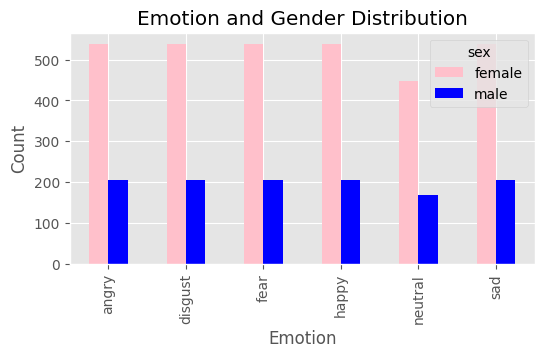

In [9]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(df)

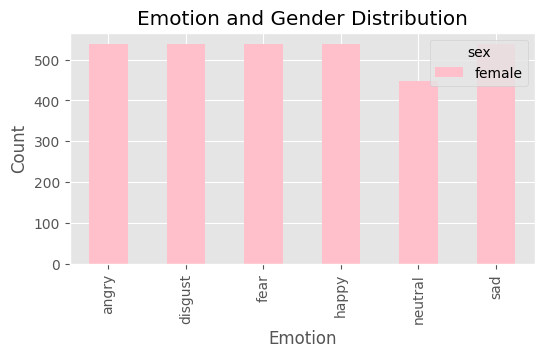

In [10]:
# I decided to go with a female specific model 
df = df[df['sex'] == 'female']
plot_distribution(df)

Dihapus kolom "sex" karena tidak diperlukan dalam training

In [11]:
df.drop('sex', axis=1, inplace=True)
df.head()

,path,emotion
44,ravdess-emotional-speech-audio/audio_speech_ac...,neutral
45,ravdess-emotional-speech-audio/audio_speech_ac...,neutral
46,ravdess-emotional-speech-audio/audio_speech_ac...,neutral
47,ravdess-emotional-speech-audio/audio_speech_ac...,neutral
48,ravdess-emotional-speech-audio/audio_speech_ac...,happy


In [12]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

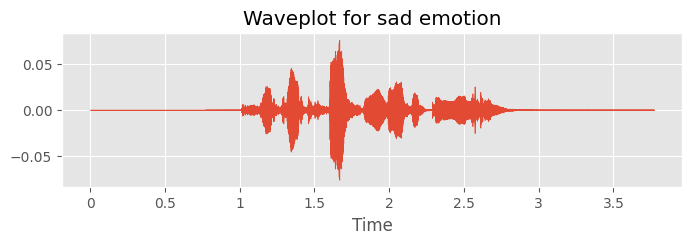

In [13]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)

# 3. Praproses

Dilakukan beberapa langkah dalam praproses audio:

1. Mendapat array dari audio
2. Menghilangkan suara hening
3. Padding untuk panjang yang sama

In [14]:
!pip install ffmpeg

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from pydub import AudioSegment, effects

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


- Audio dibaca dalam format yang ditentukan oleh `AudioSegment` dari `pydub` supaya dapat dimanipulasi dalam bentuk angka (float32).
- Setelah itu, dihapus bagian audio yang memiliki amplitudo di bawah batas (top_db = 25 dB). Bagian ini biasanya adalah suara yang hening.
- Menambahkan nilai nol (padding) di akhir array audio agar panjang audio sama/seragam, yaitu 180.000 sampel.

In [16]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [17]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

# 4. Extract features

Ada tiga fitur yang diekstrak:

1. Zero Crossing Rate

Mengambil perubahan tanda (positif ke negatif atau sebaliknya) dalam sinyal per detik untuk membedakan emosi berdasarkan kecepatan dan sifat suara.
Suara bernada tinggi atau cepat seperti "angry" cenderung memiliki ZCR yang lebih tinggi dibandingkan suara yang lebih lambat atau tenang seperti "sad".

2. Root Mean Square Energy

Mengukur intensitas atau kekuatan suara untuk mendapat energi emosi.
Emosi "angry" atau "fear" biasanya memiliki RMS Energy yang lebih tinggi karena suara lebih keras atau intens. Sebaliknya, "sad" memiliki energi yang lebih rendah karena suara lebih lembut dan tenang.

3. Mel-Frequency Cepstral Coefficients

Merepresentasikan pola frekuensi dan mendapat tekstur suara yang menyerupai persepsi pendengaran manusia, seperti intonasi, nada, dan dinamika suara.

In [18]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav


C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\pydub\utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


Failed for path: toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_germ_angry.wav
Failed for path: toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_neat_fear.wav


In [19]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

# 5. Build a LSTM

Sinyal audio adalah data urutan (_sequential data_) yang memiliki ketergantungan waktu. Emosi pada suara ditentukan oleh pola suara secara keseluruhan, sehingga LSTM yang menangkap hubungan jangka panjang dan pola temporal dalam data cocok untuk kasus ini.

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [21]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [22]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks
from keras.layers import Dense, LSTM, Dropout, Bidirectional

In [23]:
MODEL = Sequential()

MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

# MODEL.add(layers.LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
# MODEL.add(layers.LSTM(128))
# MODEL.add(layers.Dense(64, activation='relu'))
# MODEL.add(layers.Dense(6, activation='softmax'))

# MODEL.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print(MODEL.summary())

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 352, 64)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,894 (210.52 KB)

 Trainable params: 53,894 (210.52 KB)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])

# applying early stopping for all models
early_stop = callbacks.EarlyStopping(monitor='val_accuracy',
                                     patience=10,
                                     restore_best_weights=True,
                                     mode='max')
model_checkpoint = callbacks.ModelCheckpoint('model/best_model_03122024_400.keras',
                                             save_best_only=True,
                                             monitor='val_accuracy',
                                             mode='max')
# reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=0.00001)

In [25]:
# model = MODEL.fit(X_train, y_train_class, epochs=400, batch_size=64, validation_data=(X_val, y_val_class))
model = MODEL.fit(X_train,
                  y_train_class,
                  epochs=400,
                  batch_size=6,
                  validation_data=(X_val, y_val_class),
                  callbacks=[early_stop, model_checkpoint])

Epoch 1/400
461/461 ━━━━━━━━━━━━━━━━━━━━ 48s 99ms/step - categorical_accuracy: 0.2361 - loss: 1.7020 - val_categorical_accuracy: 0.2433 - val_loss: 1.5699
Epoch 2/400
  1/461 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - categorical_accuracy: 0.1667 - loss: 1.5955

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: categorical_accuracy,loss,val_categorical_accuracy,val_loss
  current = self.get_monitor_value(logs)
C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


461/461 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - categorical_accuracy: 0.3132 - loss: 1.4840 - val_categorical_accuracy: 0.3194 - val_loss: 1.4934
Epoch 3/400
461/461 ━━━━━━━━━━━━━━━━━━━━ 47s 102ms/step - categorical_accuracy: 0.3848 - loss: 1.3973 - val_categorical_accuracy: 0.4183 - val_loss: 1.2725
Epoch 4/400
461/461 ━━━━━━━━━━━━━━━━━━━━ 48s 103ms/step - categorical_accuracy: 0.4208 - loss: 1.3368 - val_categorical_accuracy: 0.2738 - val_loss: 1.6096
Epoch 5/400
461/461 ━━━━━━━━━━━━━━━━━━━━ 47s 102ms/step - categorical_accuracy: 0.4213 - loss: 1.2953 - val_categorical_accuracy: 0.4183 - val_loss: 1.3256
Epoch 6/400
461/461 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - categorical_accuracy: 0.4419 - loss: 1.2710 - val_categorical_accuracy: 0.4639 - val_loss: 1.2048
Epoch 7/400
461/461 ━━━━━━━━━━━━━━━━━━━━ 47s 102ms/step - categorical_accuracy: 0.4807 - loss: 1.1938 - val_categorical_accuracy: 0.4259 - val_loss: 1.2572
Epoch 8/400
461/461 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - categorical_accura

# 6. Evaluate and conclude

Let's see how good are model is. 

In [26]:
from sklearn.metrics import confusion_matrix

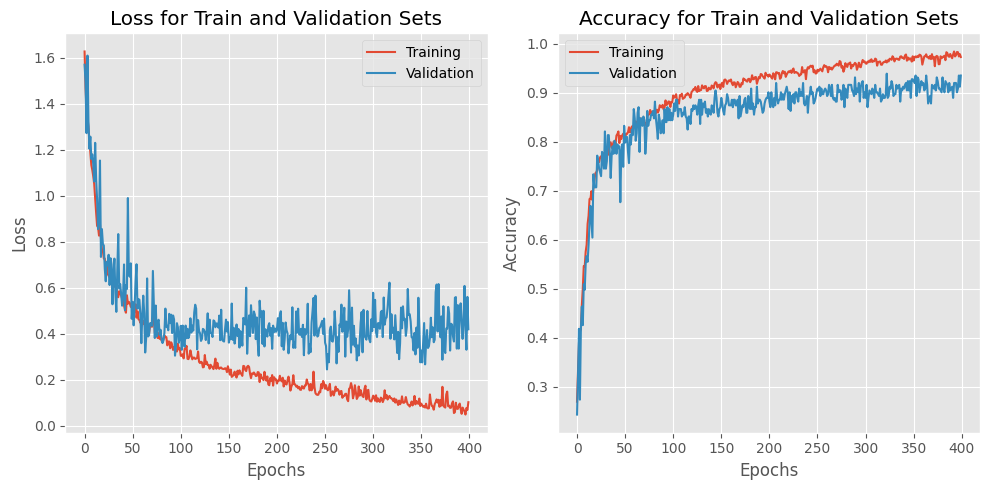

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

Ditunjukkan bahwa model belajar dengan baik, walaupun sempat mengalami penurunan akurasi pada epoch tertentu.

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


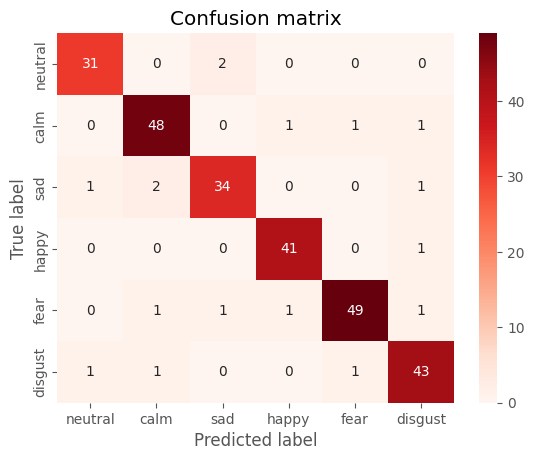

In [28]:
import seaborn as sns

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [29]:
# add classification report
from sklearn.metrics import classification_report

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
y_true = np.argmax(y_val_class, axis=1)

print(classification_report(y_true, y_pred, target_names=labels))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
              precision    recall  f1-score   support

     neutral       0.94      0.94      0.94        33
        calm       0.92      0.94      0.93        51
         sad       0.92      0.89      0.91        38
       happy       0.95      0.98      0.96        42
        fear       0.96      0.92      0.94        53
     disgust       0.91      0.93      0.92        46

    accuracy                           0.94       263
   macro avg       0.94      0.94      0.93       263
weighted avg       0.94      0.94      0.94       263



In [30]:
# evaluate with MSE
from sklearn.metrics import mean_squared_error

y_pred = MODEL.predict(X_val)
y_pred_class = np.argmax(y_pred, axis=1)
print(y_pred_class)
y_true = y_val_class
y_true_class = np.argmax(y_true, axis=1)
print(y_true_class)

# Calculate MSE
mse = mean_squared_error(y_true_class, y_pred_class)
print("Mean Squared Error (MSE):", mse)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[0 0 2 2 1 0 1 2 2 3 3 1 1 1 3 1 5 5 0 3 5 4 4 2 5 5 5 1 1 4 5 3 0 5 2 3 5
 5 4 1 4 2 2 0 3 3 1 4 2 3 4 2 5 1 4 4 4 4 5 2 3 1 4 1 2 1 3 5 2 4 1 0 3 1
 2 5 2 0 3 0 5 5 4 0 1 5 2 3 5 3 2 0 5 0 0 5 3 4 4 1 5 4 1 4 4 2 0 2 3 4 3
 4 1 3 5 5 1 0 1 2 3 4 0 1 1 1 1 4 5 1 4 3 1 4 4 1 3 4 4 0 1 5 2 3 2 5 2 0
 1 4 2 3 0 5 0 4 3 1 0 0 5 2 2 2 4 1 3 4 1 4 3 4 4 5 5 0 2 5 1 5 2 5 2 5 0
 1 3 3 3 0 3 0 5 0 0 5 2 0 5 4 1 2 1 0 4 1 2 3 3 1 3 4 0 5 2 5 4 1 1 3 2 3
 4 2 3 4 5 1 1 4 3 4 5 1 1 4 0 4 4 1 4 5 4 5 4 1 4 4 2 3 3 5 5 1 1 1 5 3 3
 1 0 3 5]
[0 0 0 2 1 5 1 2 2 3 3 1 1 1 3 1 5 1 0 3 5 4 4 2 5 5 5 1 1 4 5 3 0 5 2 3 5
 5 4 1 4 2 4 0 3 3 1 4 2 3 4 2 5 1 4 4 4 4 5 2 3 1 4 1 2 1 3 3 0 4 1 0 3 2
 2 5 2 0 3 0 5 5 4 0 1 5 2 3 5 3 2 0 5 0 0 5 3 4 4 1 5 4 1 4 1 2 2 2 3 4 3
 4 1 3 2 5 1 0 4 2 3 4 0 1 1 1 1 4 5 1 5 3 5 4 4 1 3 4 4 0 1 4 2 3 2 5 2 0
 1 4 2 3 0 5 0 4 3 1 0 0 5 2 2 2 4 1 3 4 1 4 3 4 4 5 5 0 2 5 1 5 2 5 2 5 0
 1 3 3 3 0 3 0 5 0 0 5 2 0 5 4 1 2 1 0 4 1 2 3 3 1 3

# Kesimpulan

Sebagai kesimpulan, model yang dikembangkan berhasil mencapai akurasi sebesar 94% dalam mengklasifikasikan 6 emosi yang berbeda. Setelah dilakukan percobaan pada beberapa dataset baru, masih terdapat kesalahan dalam mengklasifikasikan emosi tertentu.

Meskipun demikian, terdapat beberapa cara untuk meningkatkan performanya. Misalnya, model dapat dimodifikasi, dataset yang lebih berkualitas dapat diperoleh, atau fitur yang berbeda dapat diekstraksi sehingga dapat menghasilkan akurasi yang lebih tinggi dan komputasi yang lebih cepat.

In [31]:
# Save the highest accuracy model
MODEL.save('model/model_03122024_400.h5')

# Save the model history
import pickle

with open('model_history_03122024_400.pkl', 'wb') as file_pi:
    pickle.dump(model.history, file_pi)

In [34]:
# see history of model
with open('model_history_03122024_400.pkl', 'rb') as file_pi:
    history = pickle.load(file_pi)

print(history)

{'categorical_accuracy': [0.2696344554424286, 0.32899022102355957, 0.3897936940193176, 0.4125950038433075, 0.4173000454902649, 0.46615996956825256, 0.5005428791046143, 0.5465074181556702, 0.5450597405433655, 0.5758233666419983, 0.5899384617805481, 0.6326456665992737, 0.6489323377609253, 0.6833152174949646, 0.6840391159057617, 0.69923996925354, 0.6811437010765076, 0.7043069005012512, 0.7205935716629028, 0.735432505607605, 0.737966001033783, 0.7423090934753418, 0.7600434422492981, 0.7589576840400696, 0.7683677077293396, 0.7705392837524414, 0.7669200301170349, 0.7687296271324158, 0.777053952217102, 0.7676438689231873, 0.7676438689231873, 0.7774158716201782, 0.7730727195739746, 0.7861020565032959, 0.7973217368125916, 0.7991313934326172, 0.7879117131233215, 0.7922548055648804, 0.8002171516418457, 0.8013029098510742, 0.7951502203941345, 0.8128845691680908, 0.8161419034004211, 0.8212088346481323, 0.7976836562156677, 0.8121606707572937, 0.8056460618972778, 0.813246488571167, 0.8165038228034973